<a href="https://colab.research.google.com/github/GaboLara998/ProyectoIntegrador/blob/main/ProyectoIntregrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segundo enfoque

In [18]:
#Segundo intento
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#Funcion de cargar datasets
def cargar_datos(link):
    datos = pd.read_csv(link,index_col='id')
    return datos


def aplicarLabelEncoder(dataset):
    encoder = LabelEncoder()
    for columna in dataset.columns:
        dataset[columna] = encoder.fit_transform(dataset[columna])
    return dataset

#Links datasets
link_training = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_training-set.csv?token=GHSAT0AAAAAACMBWAOFBU5CFZ67HIDC2XLOZO7JZMA"
link_testing = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_testing-set.csv?token=GHSAT0AAAAAACMBWAOFEFKXDJN42NYN2ZDAZO7JXNA"


# Cargar los datos
datos_training = cargar_datos(link_training)
datos_testing = cargar_datos(link_testing)


# creating one-whole dataframe which contains all data
dataFinal = pd.concat([datos_training,datos_testing])
dataFinal = dataFinal.reset_index(drop=True)


In [19]:
# getting the attack category column
dataFinal.attack_cat.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [20]:
dataFinal=aplicarLabelEncoder(dataFinal)

#Seleccion de caracteristicas y clase de salida
X_features=dataFinal.iloc[:,1:45]
y_label=dataFinal.iloc[:,0]

In [21]:
# some columns should be change from string to categoriacal
for col in ['proto', 'service', 'state']:
    dataFinal[col] = dataFinal[col].astype('category').cat.codes
    dataFinal[col] = dataFinal[col].astype('category').cat.codes

dataFinal['attack_cat'] = dataFinal['attack_cat'].astype('category') # keep the nomical info for attack info

5    58871
3    44525
4    24246
2    16353
7    13987
0     2677
1     2329
8     1511
9      174
6        0
Name: attack_cat, dtype: int64


<Axes: ylabel='attack_cat'>

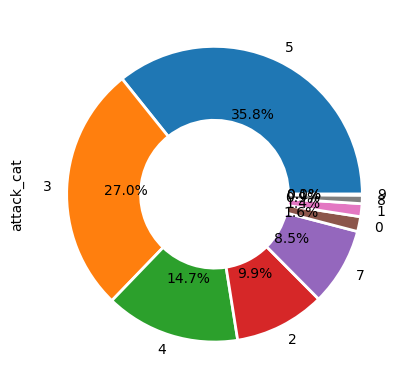

In [22]:
# explore different types of attackes
print(dataFinal[dataFinal['label']==1]
     ['attack_cat']
     .value_counts()
)
# plot the pie plot of attacks
dataFinal[dataFinal['label']==1]['attack_cat'].value_counts()\
    .plot\
    .pie(autopct='%1.1f%%',wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'width': 0.50})

In [23]:
# separating the target columns in the training and testing data
from sklearn.model_selection import train_test_split

# Split the data into variables and target variables
# let's exclude label columns
X = dataFinal.loc[:, ~dataFinal.columns.isin(['attack_cat', 'label'])]
y = dataFinal['label'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Getting the list of variables
feature_names = list(X.columns)

# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Create a decision tree classifier
dt = DecisionTreeClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 1.0


In [25]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

clf=grid_search.best_estimator_

y_pred = clf.predict(X_test)

# Calculate the mean absolute error of the model
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

Recall:  1.0


In [26]:
import numpy as np

X_test = X_test.reset_index(drop=True)

# filter out testing part based on our rules
rules= "(sttl <= 61.00 & sinpkt<= 0.00) | (sttl >  61.00 )"

# getting the index of records to keep
ind = X_test.query(rules).index

# filtering test set (both X_test and y_test)
X_test_2 = X_test.loc[ind,:]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("filtered data" , (1- np.round(X_test_2.shape[0] / X_test.shape[0],2))*100, "%")

(77302, 42)
(224, 42)
filtered data 100.0 %


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

# Create a Random Forest model
rf = RandomForestClassifier(random_state=123)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_2)


# Calculate the mean absolute error of the model
acc = accuracy_score(y_test_2, y_pred)
rec = recall_score(y_test_2, y_pred)
per = precision_score(y_test_2, y_pred)
# Calculate the AUC of the model
auc = roc_auc_score(y_test_2, y_pred)


print("Recall: ", rec)
print("Percision: ", per)
print("Accuracy: ", acc)
print("AUC: ", auc)

Recall:  1.0
Percision:  0.984
Accuracy:  0.9910714285714286
AUC:  0.9900990099009901


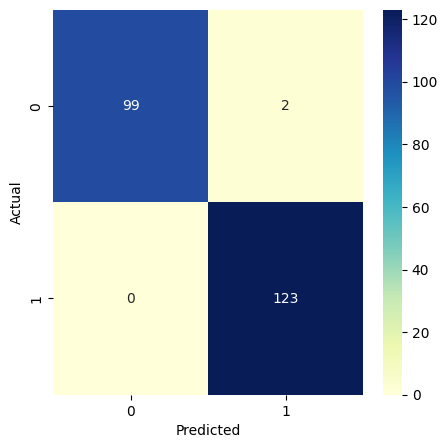

In [28]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
plt.figure(figsize=(5, 5))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()

<ipython-input-29-ac5ecb3d4784>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(dataFinal.corr(), dtype=bool))
<ipython-input-29-ac5ecb3d4784>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataFinal.corr(),vmin=-1, vmax=1,cmap='BrBG', mask=mask)


<Axes: >

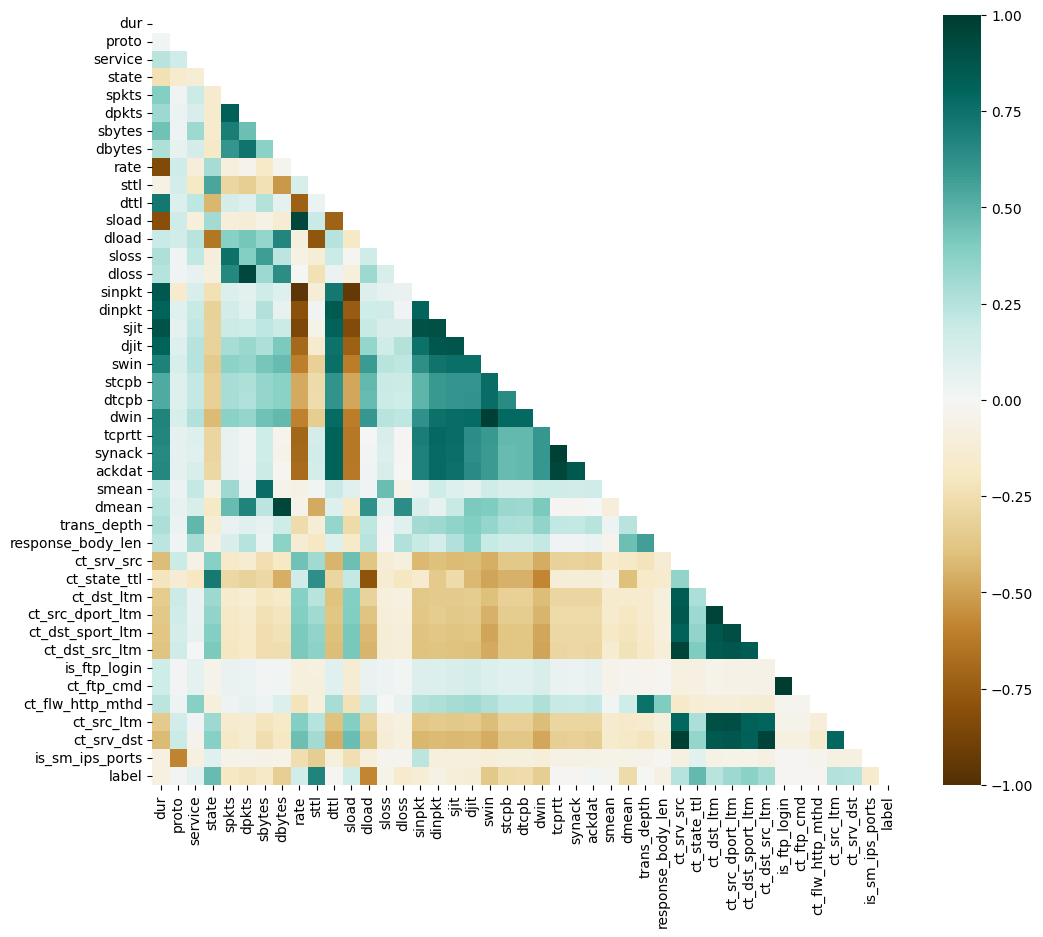

In [29]:
# creating the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(dataFinal.corr(), dtype=bool))
sns.heatmap(dataFinal.corr(),vmin=-1, vmax=1,cmap='BrBG', mask=mask)

In [30]:
# creating of ranking data frame
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf.feature_importances_})

# sorting the features based on their importance value
feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

# show only 10 most important feature in style of gradien of colores
feature_imp[:10].style.background_gradient()

,Name,Importance
0,sttl,0.145638
1,ct_state_ttl,0.106553
2,dload,0.050576
3,sload,0.049514
4,rate,0.048202
5,sbytes,0.040608
6,smean,0.040537
7,ct_dst_src_ltm,0.038640
8,dttl,0.038604
9,ct_srv_dst,0.036001


<Axes: >

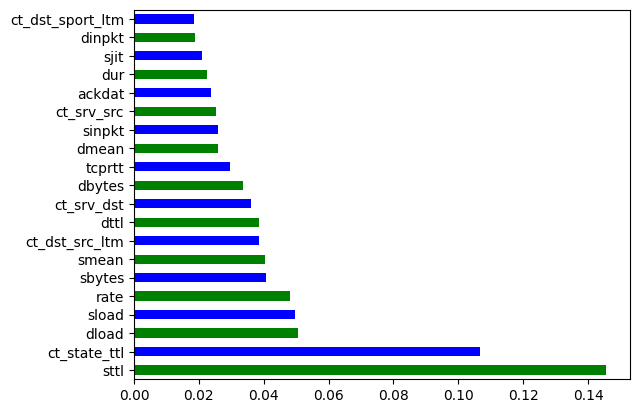

In [31]:
# plot the important features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',color=['g','b']*5)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#Funcion de cargar datasets
def cargar_datos(link):
    datos = pd.read_csv(link, index_col='id')
    return datos

# Cargar los datos
link_training = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_training-set.csv?token=GHSAT0AAAAAACMBWAOFBU5CFZ67HIDC2XLOZO7JZMA"
link_testing = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_testing-set.csv?token=GHSAT0AAAAAACMBWAOFEFKXDJN42NYN2ZDAZO7JXNA"

datos_training = cargar_datos(link_training)
datos_testing = cargar_datos(link_testing)

# Combinar datos de entrenamiento y prueba
dataFinal = pd.concat([datos_training, datos_testing])
dataFinal = dataFinal.reset_index(drop=True)

# Codificar variables categóricas
encoder = LabelEncoder()
for col in ['proto', 'service', 'state', 'attack_cat']:
    dataFinal[col] = encoder.fit_transform(dataFinal[col])

# Dividir datos en características y etiquetas
X = dataFinal.drop(['attack_cat', 'label'], axis=1)
y = dataFinal['label']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Entrenar y evaluar Isolation Forest
if_model = IsolationForest()
if_model.fit(X_train)
if_predictions = if_model.predict(X_test)
if_labels = np.where(if_predictions == -1, 1, 0)  # Anomalía es -1

# Entrenar y evaluar One-Class SVM
svm_model = OneClassSVM()
svm_model.fit(X_train)
svm_predictions = svm_model.predict(X_test)
svm_labels = np.where(svm_predictions == -1, 1, 0)

# Entrenar Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Evaluar Autoencoder
autoencoder_predictions = autoencoder.predict(X_test)
autoencoder_losses = np.mean(np.square(X_test - autoencoder_predictions), axis=1)
autoencoder_labels = np.where(autoencoder_losses > np.mean(autoencoder_losses), 1, 0)

# Entrenar y evaluar Random Forest
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)




Epoch 1/10
5637/5637 [==============================] - 16s 3ms/step - loss: 138155165038411776.0000 - val_loss: 136953149721149440.0000
Epoch 2/10
5637/5637 [==============================] - 15s 3ms/step - loss: 138155001829654528.0000 - val_loss: 136953149721149440.0000
Epoch 3/10
5637/5637 [==============================] - 15s 3ms/step - loss: 138155036189392896.0000 - val_loss: 136953149721149440.0000
Epoch 4/10
5637/5637 [==============================] - 14s 3ms/step - loss: 138154907340374016.0000 - val_loss: 136953149721149440.0000
Epoch 5/10
5637/5637 [==============================] - 24s 4ms/step - loss: 138155362606907392.0000 - val_loss: 136953149721149440.0000
Epoch 6/10
5637/5637 [==============================] - 12s 2ms/step - loss: 138155199398150144.0000 - val_loss: 136953149721149440.0000
Epoch 7/10
5637/5637 [==============================] - 12s 2ms/step - loss: 138154933110177792.0000 - val_loss: 136953149721149440.0000
Epoch 8/10
5637/5637 [===================

Isolation Forest:
Accuracy: 0.3495899200538149
Precision: 0.3654029945842625
Recall: 0.023203123419578014
AUC: 0.47586292738491187

One-Class SVM:
Accuracy: 0.32156994644381776
Precision: 0.4609011816647189
Recall: 0.35901118685898087
AUC: 0.3070846238934468

Autoencoder:
Accuracy: 0.33915034539856664
Precision: 0.4694797516996748
Recall: 0.25703477434102723
AUC: 0.3709193391601796

Random Forest:
Accuracy: 0.9517606271506559
Precision: 0.9647738366417182
Recall: 0.9596018853802116
AUC: 0.9487269895522106


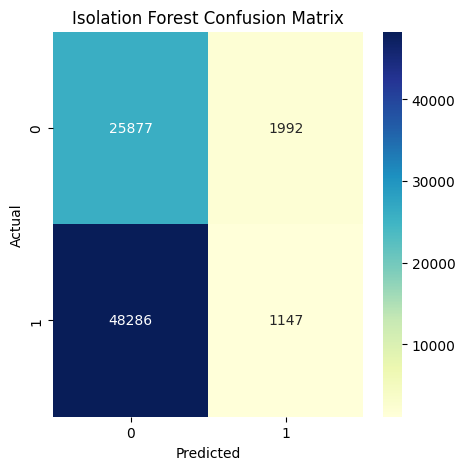

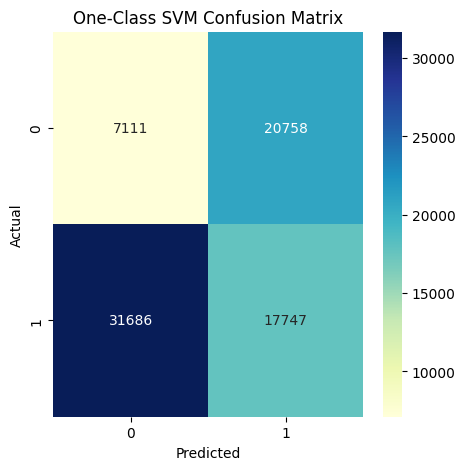

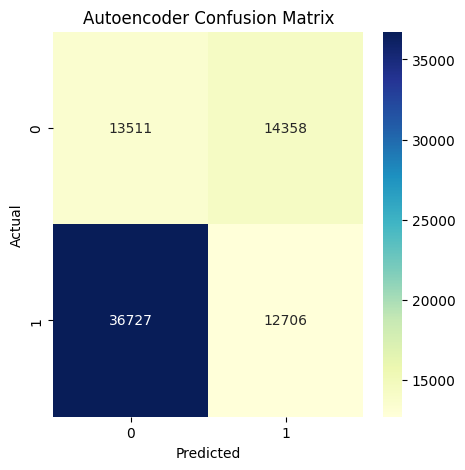

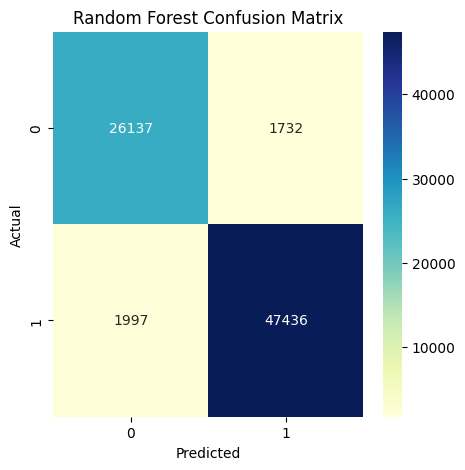

In [2]:
# Calcular métricas de rendimiento
print("Isolation Forest:")
print("Accuracy:", accuracy_score(y_test, if_labels))
print("Precision:", precision_score(y_test, if_labels))
print("Recall:", recall_score(y_test, if_labels))
print("AUC:", roc_auc_score(y_test, if_labels))

print("\nOne-Class SVM:")
print("Accuracy:", accuracy_score(y_test, svm_labels))
print("Precision:", precision_score(y_test, svm_labels))
print("Recall:", recall_score(y_test, svm_labels))
print("AUC:", roc_auc_score(y_test, svm_labels))

print("\nAutoencoder:")
print("Accuracy:", accuracy_score(y_test, autoencoder_labels))
print("Precision:", precision_score(y_test, autoencoder_labels))
print("Recall:", recall_score(y_test, autoencoder_labels))
print("AUC:", roc_auc_score(y_test, autoencoder_labels))

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_pred_rf))

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, if_labels, "Isolation Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm_labels, "One-Class SVM Confusion Matrix")
plot_confusion_matrix(y_test, autoencoder_labels, "Autoencoder Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#Funcion de cargar datasets
def cargar_datos(link):
    datos = pd.read_csv(link, index_col='id')
    return datos

# Cargar los datos
link_training = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_training-set.csv?token=GHSAT0AAAAAACMBWAOFBU5CFZ67HIDC2XLOZO7JZMA"
link_testing = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_testing-set.csv?token=GHSAT0AAAAAACMBWAOFEFKXDJN42NYN2ZDAZO7JXNA"

datos_training = cargar_datos(link_training)
datos_testing = cargar_datos(link_testing)

# Combinar datos de entrenamiento y prueba
dataFinal = pd.concat([datos_training, datos_testing])
dataFinal = dataFinal.reset_index(drop=True)

# Codificar variables categóricas
encoder = LabelEncoder()
for col in ['proto', 'service', 'state', 'attack_cat']:
    dataFinal[col] = encoder.fit_transform(dataFinal[col])

# Dividir datos en características y etiquetas
X = dataFinal.drop(['attack_cat', 'label'], axis=1)
y = dataFinal['label']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)



# Entrenar y evaluar One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
svm_model.fit(X_train)
svm_predictions = svm_model.predict(X_test)
svm_labels = np.where(svm_predictions == -1, 1, 0)




One-Class SVM:
Accuracy: 0.45627538744146334
Precision: 0.5652365508002538
Recall: 0.6486962150789958
AUC: 0.38183133262830626


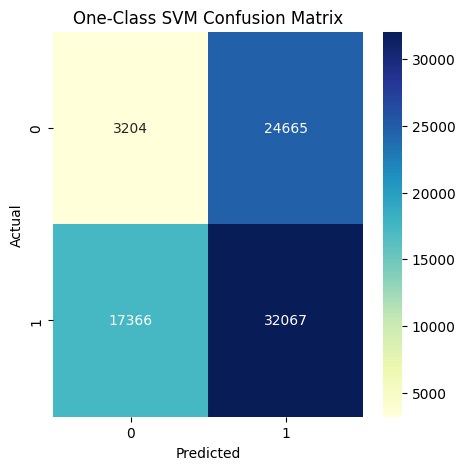

In [2]:
# Calcular métricas de rendimiento


print("\nOne-Class SVM:")
print("Accuracy:", accuracy_score(y_test, svm_labels))
print("Precision:", precision_score(y_test, svm_labels))
print("Recall:", recall_score(y_test, svm_labels))
print("AUC:", roc_auc_score(y_test, svm_labels))


# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, svm_labels, "One-Class SVM Confusion Matrix")


K-Nearest Neighbors:
Accuracy: 0.8494734935706709
Precision: 0.8722302101593429
Recall: 0.8958388121295491
AUC: 0.8315356104495749


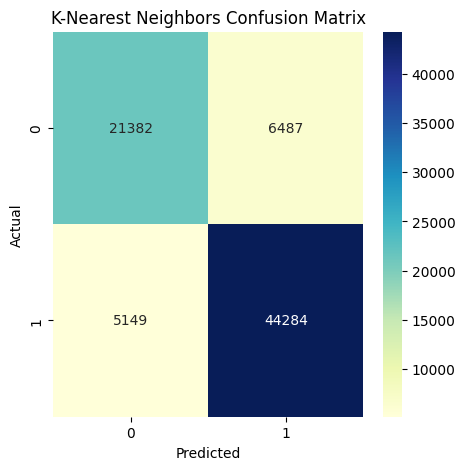

In [3]:
from sklearn.neighbors import KNeighborsClassifier

# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)

# Entrenar el modelo
knn_model.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
knn_predictions = knn_model.predict(X_test)

# Calcular métricas de rendimiento
print("\nK-Nearest Neighbors:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Precision:", precision_score(y_test, knn_predictions))
print("Recall:", recall_score(y_test, knn_predictions))
print("AUC:", roc_auc_score(y_test, knn_predictions))

# Graficar la matriz de confusión
plot_confusion_matrix(y_test, knn_predictions, "K-Nearest Neighbors Confusion Matrix")


XGBoost:
Accuracy: 0.9475434012056609
Precision: 0.9649004179985247
Recall: 0.9526227418930674
AUC: 0.9455782983569179


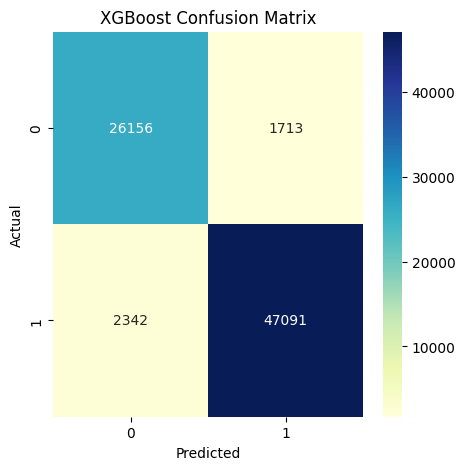

In [5]:
import xgboost as xgb

# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=123)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
xgb_predictions = xgb_model.predict(X_test)

# Calcular métricas de rendimiento
print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Precision:", precision_score(y_test, xgb_predictions))
print("Recall:", recall_score(y_test, xgb_predictions))
print("AUC:", roc_auc_score(y_test, xgb_predictions))

# Graficar la matriz de confusión
plot_confusion_matrix(y_test, xgb_predictions, "XGBoost Confusion Matrix")


In [2]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=626c224d6b31593d0fc4811a194d7769db5eb8fbfdfe1f28e6a07ec3c3a18470
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [5]:
from sklearn.cluster import KMeans
from minisom import MiniSom
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#Funcion de cargar datasets
def cargar_datos(link):
    datos = pd.read_csv(link, index_col='id')
    return datos

# Cargar los datos
link_training = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_training-set.csv?token=GHSAT0AAAAAACMBWAOFBU5CFZ67HIDC2XLOZO7JZMA"
link_testing = "https://raw.githubusercontent.com/GaboLara998/ProyectoIntegrador/main/DataSet_UNSW_NB15/UNSW_NB15_testing-set.csv?token=GHSAT0AAAAAACMBWAOFEFKXDJN42NYN2ZDAZO7JXNA"

datos_training = cargar_datos(link_training)
datos_testing = cargar_datos(link_testing)

# Combinar datos de entrenamiento y prueba
dataFinal = pd.concat([datos_training, datos_testing])
dataFinal = dataFinal.reset_index(drop=True)

# Codificar variables categóricas
encoder = LabelEncoder()
for col in ['proto', 'service', 'state', 'attack_cat']:
    dataFinal[col] = encoder.fit_transform(dataFinal[col])

# Dividir datos en características y etiquetas
X = dataFinal.drop(['attack_cat', 'label'], axis=1)
y = dataFinal['label']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)



# Crear el modelo KMeans
kmeans = KMeans(n_clusters=2, random_state=0)

# Entrenar el modelo
kmeans.fit(X_train)

# Hacer predicciones en los datos de prueba
kmeans_predictions = kmeans.predict(X_test)

# Crear el modelo SOM
som = MiniSom(x=10, y=10, input_len=X_train.shape[1])

# Entrenar el modelo
som.train_random(np.array(X_train), 100)

# Hacer predicciones en los datos de prueba
som_predictions = [som.winner(x) for x in X_test]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('float64')) -> None